# AutoEncoder with MLP

- 발표자: 통합과정 최찬혁

In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets
from torchsummary import summary as summary_
import matplotlib.pyplot as plt
import numpy as np

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [24]:
EPOCHS = 30
BATCH_SIZE = 64
NUM_WORKERS = 4
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4

In [5]:
# Fashion MNIST 데이터셋 불러오기
trainset = datasets.FashionMNIST(
    root      = './Data/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)

testset = datasets.FashionMNIST(
    root      = './Data/', 
    train     = False,
    download  = True,
    transform = transforms.ToTensor()
)

In [8]:
trainset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = NUM_WORKERS
)

test_loader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = BATCH_SIZE,
    shuffle     = False,
    num_workers = NUM_WORKERS
)

In [26]:
28*28//16

49

In [13]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim//4),
            nn.ReLU(),
            nn.Linear(input_dim//4, input_dim//16),
            nn.ReLU(),
            nn.Linear(input_dim//16, latent_dim),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, input_dim//16),
            nn.ReLU(),
            nn.Linear(input_dim//16, input_dim//4),
            nn.ReLU(),
            nn.Linear(input_dim//4, input_dim),
            nn.Sigmoid()                              # since we normalized the input tensor to [0,1]
        )

    def forward(self, x):
        encoded = self.encoder(x)       # encoded = latent vector
        decoded = self.decoder(encoded) 
        return encoded, decoded

In [27]:
autoencoder = Autoencoder(latent_dim=10).to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY) 
criterion = nn.MSELoss()

NameError: name 'LEARNING_RATE' is not defined

In [16]:
summary_(autoencoder.encoder, (28*28,) ,batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [64, 300]         235,500
              ReLU-2                  [64, 300]               0
            Linear-3                   [64, 50]          15,050
              ReLU-4                   [64, 50]               0
            Linear-5                   [64, 10]             510
Total params: 251,060
Trainable params: 251,060
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.35
Params size (MB): 0.96
Estimated Total Size (MB): 1.50
----------------------------------------------------------------


In [18]:
summary_(autoencoder.decoder, (10,) ,batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [64, 50]             550
              ReLU-2                   [64, 50]               0
            Linear-3                  [64, 300]          15,300
              ReLU-4                  [64, 300]               0
            Linear-5                  [64, 784]         235,984
           Sigmoid-6                  [64, 784]               0
Total params: 251,834
Trainable params: 251,834
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.11
Params size (MB): 0.96
Estimated Total Size (MB): 2.07
----------------------------------------------------------------


In [19]:
# Choose the first ten images from testset for visualization.

view_data = testset.data[:10].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.

In [20]:
def train(autoencoder, train_loader, device):
    autoencoder.train()
    total_loss=0
    
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(device)
        y = x.view(-1, 28*28).to(device)
        label = label.to(device)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y)
        total_loss += loss
        
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step()

    total_loss = total_loss.item()
    print("total train loss:" + str(total_loss))
    
    return total_loss

In [21]:
def test(autoencoder, test_loader, device):
    autoencoder.eval()
    total_loss=0
    for step, (x, label) in enumerate(test_loader):
        x = x.view(-1, 28*28).to(device)
        y = x.view(-1, 28*28).to(device)
        label = label.to(device)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y)
        total_loss += loss

    total_loss = total_loss.item()
    print("total test loss:" + str(total_loss))
    
    return total_loss

total train loss:22.725263595581055
total test loss:2.8210487365722656
[Epoch 1]


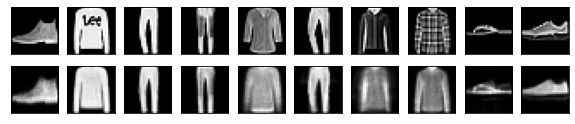

total train loss:15.771833419799805
total test loss:2.5287299156188965
[Epoch 2]


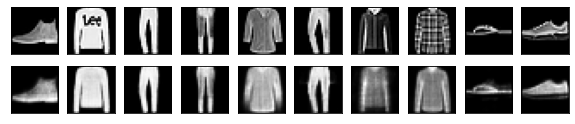

total train loss:14.649728775024414
total test loss:2.445875644683838
[Epoch 3]


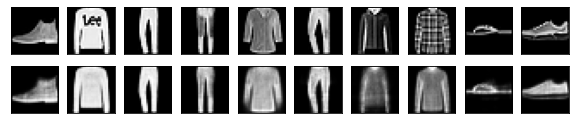

total train loss:13.978854179382324
total test loss:2.335052728652954
[Epoch 4]


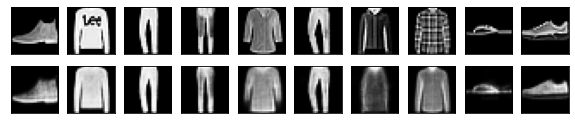

total train loss:13.482699394226074
total test loss:2.304626226425171
[Epoch 5]


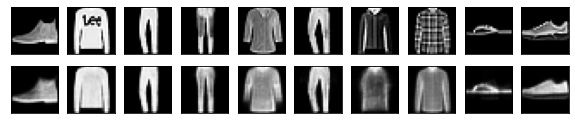

total train loss:13.219562530517578
total test loss:2.207167148590088
[Epoch 6]


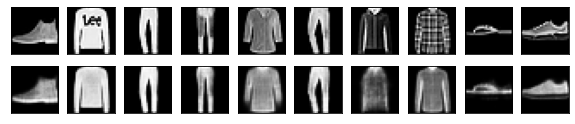

total train loss:13.024292945861816
total test loss:2.277588367462158
[Epoch 7]


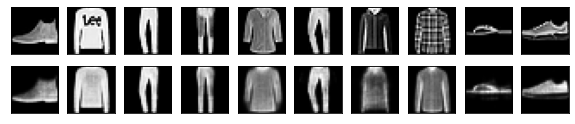

total train loss:12.793328285217285
total test loss:2.1577999591827393
[Epoch 8]


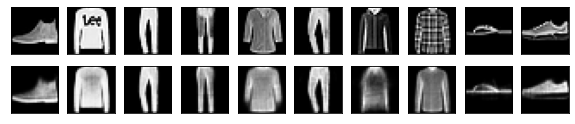

total train loss:12.630398750305176
total test loss:2.1963906288146973
[Epoch 9]


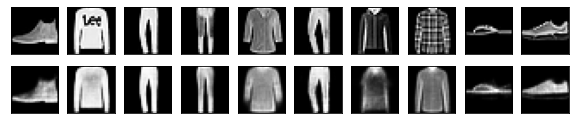

total train loss:12.525313377380371
total test loss:2.1074612140655518
[Epoch 10]


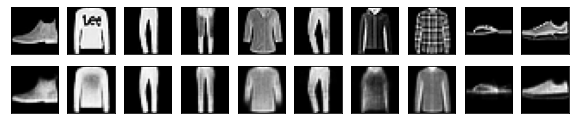

total train loss:12.479225158691406
total test loss:2.1287410259246826
[Epoch 11]


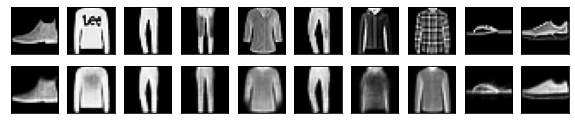

total train loss:12.39483642578125
total test loss:2.1547999382019043
[Epoch 12]


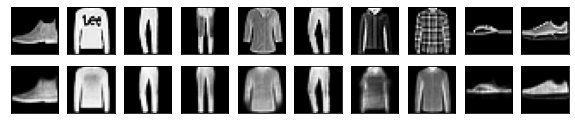

total train loss:12.319080352783203
total test loss:2.0971944332122803
[Epoch 13]


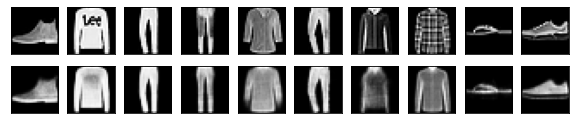

total train loss:12.23029899597168
total test loss:2.082944393157959
[Epoch 14]


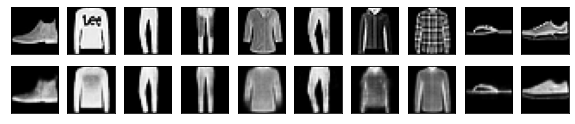

total train loss:12.194928169250488
total test loss:2.1206061840057373
[Epoch 15]


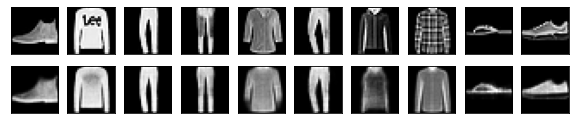

total train loss:12.196441650390625
total test loss:2.100616455078125
[Epoch 16]


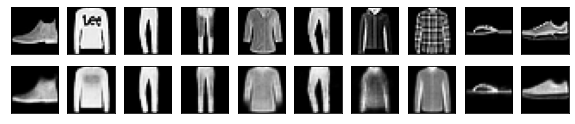

total train loss:12.137693405151367
total test loss:2.0921199321746826
[Epoch 17]


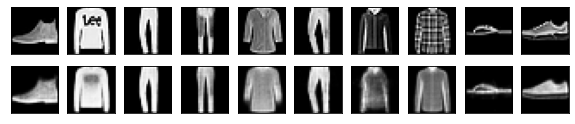

total train loss:12.089459419250488
total test loss:2.05056095123291
[Epoch 18]


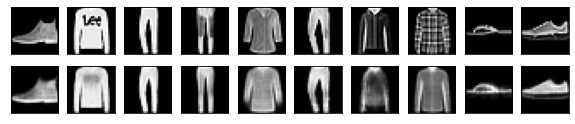

total train loss:12.11112117767334
total test loss:2.08054256439209
[Epoch 19]


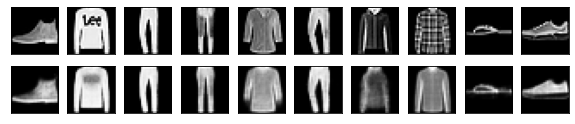

total train loss:12.026268005371094
total test loss:2.0516340732574463
[Epoch 20]


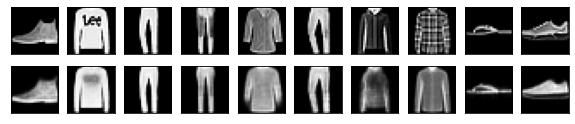

total train loss:12.016523361206055
total test loss:2.0822081565856934
[Epoch 21]


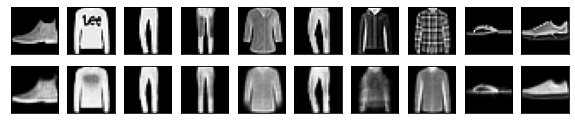

total train loss:12.018404006958008
total test loss:2.0350656509399414
[Epoch 22]


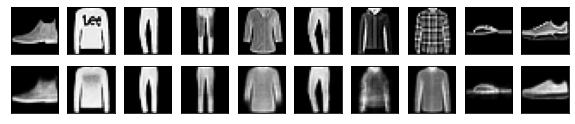

total train loss:12.003122329711914
total test loss:2.070632219314575
[Epoch 23]


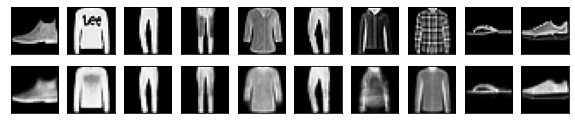

total train loss:11.928396224975586
total test loss:2.1622042655944824
[Epoch 24]


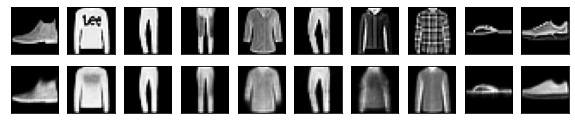

total train loss:11.947054862976074
total test loss:2.0661919116973877
[Epoch 25]


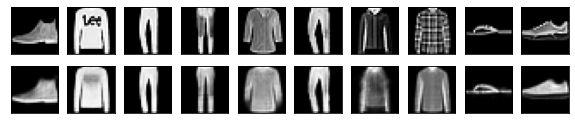

total train loss:11.930367469787598
total test loss:2.053720474243164
[Epoch 26]


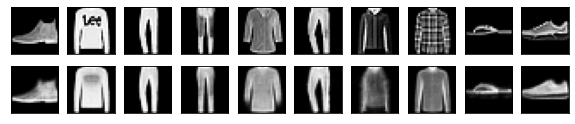

total train loss:11.900545120239258
total test loss:2.0458860397338867
[Epoch 27]


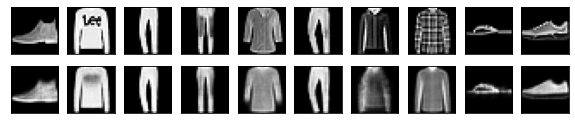

total train loss:11.882851600646973
total test loss:2.032198905944824
[Epoch 28]


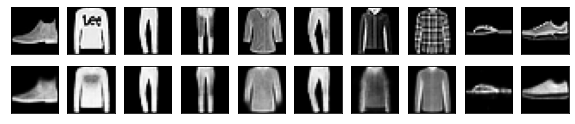

total train loss:11.904726028442383
total test loss:2.1120731830596924
[Epoch 29]


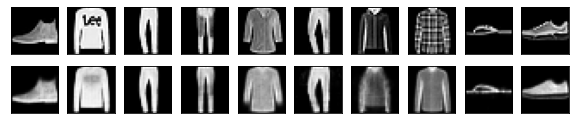

total train loss:11.873997688293457
total test loss:2.064142942428589
[Epoch 30]


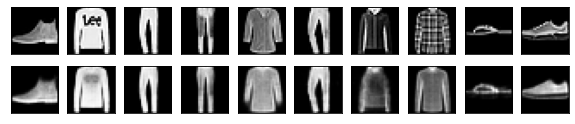

In [22]:
train_losses=[]
test_losses=[]


for epoch in range(1, EPOCHS+1):
    loss_epoch = train(autoencoder, train_loader, DEVICE)
    train_losses.append(loss_epoch)

    loss_epoch = test(autoencoder, test_loader, DEVICE)
    test_losses.append(loss_epoch)

    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    # 원본과 디코딩 결과 비교해보기
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(10):
        img = np.reshape(view_data.data.numpy()[i],(28, 28)) #파이토치 텐서를 넘파이로 변환합니다.
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())

    for i in range(10):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28)) 
        # CUDA를 사용하면 모델 출력값이 GPU에 남아있으므로 .to("cpu") 함수로 일반메모리로 가져와 numpy행렬로 변환합니다.
        # cpu를 사용할때에도 같은 코드를 사용해도 무방합니다.
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

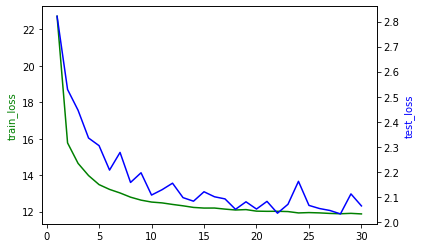

In [23]:
x = range(1,EPOCH+1)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(x, train_losses, 'g-')
ax2.plot(x, test_losses, 'b-')
ax1.set_ylabel('train_loss', color='g')
ax2.set_ylabel('test_loss', color='b')
plt.show()
